In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

# to_datetime

train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

> test,train 분기별(or 시간대별) 분리 <br>
> 군집분석 <br>
> 군집별 모델링 <br>

In [5]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [6]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

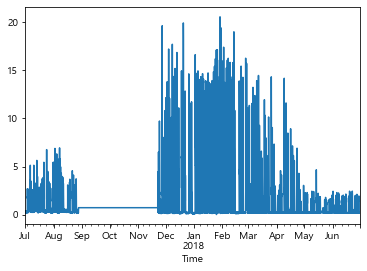

In [7]:
test_sample['X125'].plot()

In [8]:
test['Tim'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

KeyError: 'Time'

In [ ]:
# 기상 데이터 load

weather_time = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_시간별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_time['지점']

weather_day= pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_일별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_day['지점']

weather_month= pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_월별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_month['지점']

# test_sample['기온'] = weather['기온(°C)']

In [ ]:
test_sample

In [ ]:
train_s = test_sample.loc['2017-12':'2018-05',['X125']]
test_s = test_sample.loc['2018-06':, ['X125']]


train_t = test_sample.loc['2017-12':'2018-05',['기온']]
test_t = test_sample.loc['2018-06':, ['기온']]

# Feature는 Unadjusted 한 개

# ax = train_s.plot()
# test_s.plot(ax=ax)
# plt.legend(['train_s', 'test_s'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train_s)
test_sc = sc.transform(test_s)

train_tc = sc.fit_transform(train_t)
test_tc = sc.transform(test_t)

train_sc

In [ ]:
# rnn_list_train=[]
# for i in range(len(train_sc)):
#     tmp_list = [train_sc[i][0],train_tc[i][0]]
#     rnn_list_train.append(tmp_list)
    
# rnn_list_test=[]
# for i in range(len(test_sc)):
#     tmp_list = [test_sc[i][0],test_tc[i][0]]
#     rnn_list_test.append(tmp_list)
    
# train_sc = np.array(rnn_list_train)
# test_sc = np.array(rnn_list_test) 

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'] ,index=train_s.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_s.index)
# train_sc_df.head()
train_tc_df = pd.DataFrame(train_tc, columns=['Scaled'] ,index=train_s.index)
test_tc_df = pd.DataFrame(test_tc, columns=['Scaled'], index=test_s.index)

In [ ]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
    train_tc_df['shift_{}'.format(s)] = train_tc_df['Scaled'].shift(s)
    test_tc_df['shift_{}'.format(s)] = test_tc_df['Scaled'].shift(s)

# train_sc_df.head(13)

In [ ]:
X_train = train_sc_df.dropna().drop(['Scaled'], axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
X_train_t = train_tc_df.dropna().drop(['Scaled'], axis=1)
y_train_t = train_tc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop(['Scaled'], axis=1)
y_test = test_sc_df.dropna()[['Scaled']]
X_test_t = test_tc_df.dropna().drop(['Scaled'], axis=1)
y_test_t = test_tc_df.dropna()[['Scaled']]

In [ ]:
m= []
m_x = []
for i in range(0,12):
    m = [X_train.values[0][i],X_train_t.values[0][i]]
    m_x.append(m)
    
###########################

m= []
m_y = []
for i in range(0,12):
    m = [X_test.values[0][i],X_test_t.values[0][i]]
    m_y.append(m)

In [ ]:
x_train_tmp = []    
tmp_x_train = []
s=[]
for i in range(0,4356):
    x_train_tmp.append(s)
    s = []
    for j in range(0,12):
        tmp_x_train = [X_train.values[i][j],X_train_t.values[i][j]]
        s.append(tmp_x_train)
x_train_tmp[0] = m_x

y_train_tmp = []    
tmp_y_train = []
for i in range(0,4356):
    tmp_y_train = [y_train.values[i][0],y_train_t.values[i][0]]
    y_train_tmp.append(tmp_y_train)
    
X_train = np.asarray(x_train_tmp)
Y_train = np.asarray(y_train_tmp)

#####################################################

x_test_tmp = []    
tmp_x_test = []
s=[]
for i in range(0,708):
    x_test_tmp.append(s)
    s = []
    for j in range(0,12):
        tmp_x_test = [X_test.values[i][j],X_test_t.values[i][j]]
        s.append(tmp_x_test)
x_test_tmp[0] = m_y

y_test_tmp = []    
tmp_y_test = []
for i in range(0,708):
    tmp_y_test = [y_test.values[i][0],y_test_t.values[i][0]]
    y_test_tmp.append(tmp_y_test)
    
X_test = np.asarray(x_test_tmp)
Y_test = np.asarray(y_test_tmp)

In [ ]:
print(X_train.shape)
# print(X_train)
print(X_test.shape)
# print(Y_train)
print(Y_train.shape)

In [ ]:
X_train_res = X_train
X_test_res = X_test

print("최종 DATA")
print(X_train_res.shape)
print('##################################')
# print(X_train_res)
print('##################################')
print(Y_train.shape)

In [ ]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, return_sequences=False, input_shape=(12, 2))) # (timestep, feature) 
model.add(Dense(2)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_res, Y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test_res)
print(y_pred)

In [ ]:
plt.figure()
plt.plot(y_pred)
plt.plot(Y_test)

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(Y_test,y_pred)

In [ ]:
rmse = np.sqrt(error)
rmse

In [ ]:
# 0.052472979918772915

In [ ]:
######################################3

In [ ]:
train_s = test_sample.loc['2017-12':'2018-05',['X125']]
test_s = test_sample.loc['2018-06':, ['X125']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train_s)
test_sc = sc.transform(test_s)


In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'] ,index=train_s.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_s.index)
# train_sc_df.head()

In [ ]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

# train_sc_df.head(13)

In [ ]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [ ]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [ ]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test_t)
# print(y_pred)

In [ ]:
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test,y_pred)

In [ ]:
rmse = np.sqrt(error)
rmse

In [ ]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(y_test, y_pred)

In [ ]:
# 0.03742239385103795

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=5000,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

In [ ]:
train['X692'].plot()

In [ ]:
lgbm_fit = model.fit(X_train_t, y_train)